In [43]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import (VectorSizeHint, VectorAssembler)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
import pandas as pd

In [2]:
#starting spark session
spark = SparkSession.builder.master("local").appName('Project').getOrCreate()
sc=spark.sparkContext

In [3]:
#importing csv data 
exoTrain = spark.read.csv("exoTrain.csv",header=True)
exoTest = spark.read.csv("exoTest.csv",header=True)
exoTrain.count()

5087

In [4]:
exoTrain.show()

+-----+--------+--------+--------+-------+--------+--------+-------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----

In [5]:
exoTest.show()

+-----+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------

In [6]:
#datalimit = 1000 #  limit data for debugging 100 1000 or full 5087
#exoTrain = exoTrain.limit(datalimit)
#exoTest = exoTest.limit(datalimit)

In [7]:
exoTest.count()

570

In [8]:
exoTrain.printSchema()

root
 |-- LABEL: string (nullable = true)
 |-- FLUX.1: string (nullable = true)
 |-- FLUX.2: string (nullable = true)
 |-- FLUX.3: string (nullable = true)
 |-- FLUX.4: string (nullable = true)
 |-- FLUX.5: string (nullable = true)
 |-- FLUX.6: string (nullable = true)
 |-- FLUX.7: string (nullable = true)
 |-- FLUX.8: string (nullable = true)
 |-- FLUX.9: string (nullable = true)
 |-- FLUX.10: string (nullable = true)
 |-- FLUX.11: string (nullable = true)
 |-- FLUX.12: string (nullable = true)
 |-- FLUX.13: string (nullable = true)
 |-- FLUX.14: string (nullable = true)
 |-- FLUX.15: string (nullable = true)
 |-- FLUX.16: string (nullable = true)
 |-- FLUX.17: string (nullable = true)
 |-- FLUX.18: string (nullable = true)
 |-- FLUX.19: string (nullable = true)
 |-- FLUX.20: string (nullable = true)
 |-- FLUX.21: string (nullable = true)
 |-- FLUX.22: string (nullable = true)
 |-- FLUX.23: string (nullable = true)
 |-- FLUX.24: string (nullable = true)
 |-- FLUX.25: string (nullable 

In [9]:
exoTrain.groupBy("LABEL").count().orderBy(desc("LABEL")).show()

+-----+-----+
|LABEL|count|
+-----+-----+
|    2|   37|
|    1| 5050|
+-----+-----+



In [10]:
exoTrain = exoTrain.withColumn("LABEL", when(col("LABEL") == "1","0").when(col("LABEL") == "2","1"))
exoTest = exoTest.withColumn("LABEL", when(col("LABEL") == "1","0").when(col("LABEL") == "2","1"))
#exoTrain = exoTrain.withColumn("LABEL", when(col("LABEL") == "2","1"))

In [11]:
exoTrain.groupBy("LABEL").count().orderBy(desc("LABEL")).show()

+-----+-----+
|LABEL|count|
+-----+-----+
|    1|   37|
|    0| 5050|
+-----+-----+



In [12]:
new_cols=(column.replace('.', '_') for column in exoTrain.columns)
exoTrain = exoTrain.toDF(*new_cols)
new_cols2=(column.replace('.', '_') for column in exoTest.columns)
exoTest = exoTest.toDF(*new_cols2)
exoTrain.printSchema()

root
 |-- LABEL: string (nullable = true)
 |-- FLUX_1: string (nullable = true)
 |-- FLUX_2: string (nullable = true)
 |-- FLUX_3: string (nullable = true)
 |-- FLUX_4: string (nullable = true)
 |-- FLUX_5: string (nullable = true)
 |-- FLUX_6: string (nullable = true)
 |-- FLUX_7: string (nullable = true)
 |-- FLUX_8: string (nullable = true)
 |-- FLUX_9: string (nullable = true)
 |-- FLUX_10: string (nullable = true)
 |-- FLUX_11: string (nullable = true)
 |-- FLUX_12: string (nullable = true)
 |-- FLUX_13: string (nullable = true)
 |-- FLUX_14: string (nullable = true)
 |-- FLUX_15: string (nullable = true)
 |-- FLUX_16: string (nullable = true)
 |-- FLUX_17: string (nullable = true)
 |-- FLUX_18: string (nullable = true)
 |-- FLUX_19: string (nullable = true)
 |-- FLUX_20: string (nullable = true)
 |-- FLUX_21: string (nullable = true)
 |-- FLUX_22: string (nullable = true)
 |-- FLUX_23: string (nullable = true)
 |-- FLUX_24: string (nullable = true)
 |-- FLUX_25: string (nullable 

In [13]:
exoTrain=exoTrain.select([col(c).cast("float") for c in exoTrain.columns])
exoTrain=exoTrain.withColumn("LABEL",col("LABEL").cast("int"))
exoTest=exoTest.select([col(c).cast("float") for c in exoTest.columns])
exoTest=exoTest.withColumn("LABEL",col("LABEL").cast("int"))

In [14]:
exoTrain.printSchema()

root
 |-- LABEL: integer (nullable = true)
 |-- FLUX_1: float (nullable = true)
 |-- FLUX_2: float (nullable = true)
 |-- FLUX_3: float (nullable = true)
 |-- FLUX_4: float (nullable = true)
 |-- FLUX_5: float (nullable = true)
 |-- FLUX_6: float (nullable = true)
 |-- FLUX_7: float (nullable = true)
 |-- FLUX_8: float (nullable = true)
 |-- FLUX_9: float (nullable = true)
 |-- FLUX_10: float (nullable = true)
 |-- FLUX_11: float (nullable = true)
 |-- FLUX_12: float (nullable = true)
 |-- FLUX_13: float (nullable = true)
 |-- FLUX_14: float (nullable = true)
 |-- FLUX_15: float (nullable = true)
 |-- FLUX_16: float (nullable = true)
 |-- FLUX_17: float (nullable = true)
 |-- FLUX_18: float (nullable = true)
 |-- FLUX_19: float (nullable = true)
 |-- FLUX_20: float (nullable = true)
 |-- FLUX_21: float (nullable = true)
 |-- FLUX_22: float (nullable = true)
 |-- FLUX_23: float (nullable = true)
 |-- FLUX_24: float (nullable = true)
 |-- FLUX_25: float (nullable = true)
 |-- FLUX_26: fl

In [15]:
exoTrain.show()

+-----+--------+--------+--------+-------+--------+--------+-------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----

In [16]:
exoTest.printSchema()

root
 |-- LABEL: integer (nullable = true)
 |-- FLUX_1: float (nullable = true)
 |-- FLUX_2: float (nullable = true)
 |-- FLUX_3: float (nullable = true)
 |-- FLUX_4: float (nullable = true)
 |-- FLUX_5: float (nullable = true)
 |-- FLUX_6: float (nullable = true)
 |-- FLUX_7: float (nullable = true)
 |-- FLUX_8: float (nullable = true)
 |-- FLUX_9: float (nullable = true)
 |-- FLUX_10: float (nullable = true)
 |-- FLUX_11: float (nullable = true)
 |-- FLUX_12: float (nullable = true)
 |-- FLUX_13: float (nullable = true)
 |-- FLUX_14: float (nullable = true)
 |-- FLUX_15: float (nullable = true)
 |-- FLUX_16: float (nullable = true)
 |-- FLUX_17: float (nullable = true)
 |-- FLUX_18: float (nullable = true)
 |-- FLUX_19: float (nullable = true)
 |-- FLUX_20: float (nullable = true)
 |-- FLUX_21: float (nullable = true)
 |-- FLUX_22: float (nullable = true)
 |-- FLUX_23: float (nullable = true)
 |-- FLUX_24: float (nullable = true)
 |-- FLUX_25: float (nullable = true)
 |-- FLUX_26: fl

In [17]:
from pyspark.sql.functions import col,isnan, when, count
exoTrain.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in exoTrain.columns]).show()

+-----+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---

In [18]:
print(exoTrain.columns)

['LABEL', 'FLUX_1', 'FLUX_2', 'FLUX_3', 'FLUX_4', 'FLUX_5', 'FLUX_6', 'FLUX_7', 'FLUX_8', 'FLUX_9', 'FLUX_10', 'FLUX_11', 'FLUX_12', 'FLUX_13', 'FLUX_14', 'FLUX_15', 'FLUX_16', 'FLUX_17', 'FLUX_18', 'FLUX_19', 'FLUX_20', 'FLUX_21', 'FLUX_22', 'FLUX_23', 'FLUX_24', 'FLUX_25', 'FLUX_26', 'FLUX_27', 'FLUX_28', 'FLUX_29', 'FLUX_30', 'FLUX_31', 'FLUX_32', 'FLUX_33', 'FLUX_34', 'FLUX_35', 'FLUX_36', 'FLUX_37', 'FLUX_38', 'FLUX_39', 'FLUX_40', 'FLUX_41', 'FLUX_42', 'FLUX_43', 'FLUX_44', 'FLUX_45', 'FLUX_46', 'FLUX_47', 'FLUX_48', 'FLUX_49', 'FLUX_50', 'FLUX_51', 'FLUX_52', 'FLUX_53', 'FLUX_54', 'FLUX_55', 'FLUX_56', 'FLUX_57', 'FLUX_58', 'FLUX_59', 'FLUX_60', 'FLUX_61', 'FLUX_62', 'FLUX_63', 'FLUX_64', 'FLUX_65', 'FLUX_66', 'FLUX_67', 'FLUX_68', 'FLUX_69', 'FLUX_70', 'FLUX_71', 'FLUX_72', 'FLUX_73', 'FLUX_74', 'FLUX_75', 'FLUX_76', 'FLUX_77', 'FLUX_78', 'FLUX_79', 'FLUX_80', 'FLUX_81', 'FLUX_82', 'FLUX_83', 'FLUX_84', 'FLUX_85', 'FLUX_86', 'FLUX_87', 'FLUX_88', 'FLUX_89', 'FLUX_90', 'FLUX_91'

In [19]:
allcolumn=exoTrain.columns
allcolumn.remove('LABEL')
print(allcolumn)
exoTrain.printSchema()

['FLUX_1', 'FLUX_2', 'FLUX_3', 'FLUX_4', 'FLUX_5', 'FLUX_6', 'FLUX_7', 'FLUX_8', 'FLUX_9', 'FLUX_10', 'FLUX_11', 'FLUX_12', 'FLUX_13', 'FLUX_14', 'FLUX_15', 'FLUX_16', 'FLUX_17', 'FLUX_18', 'FLUX_19', 'FLUX_20', 'FLUX_21', 'FLUX_22', 'FLUX_23', 'FLUX_24', 'FLUX_25', 'FLUX_26', 'FLUX_27', 'FLUX_28', 'FLUX_29', 'FLUX_30', 'FLUX_31', 'FLUX_32', 'FLUX_33', 'FLUX_34', 'FLUX_35', 'FLUX_36', 'FLUX_37', 'FLUX_38', 'FLUX_39', 'FLUX_40', 'FLUX_41', 'FLUX_42', 'FLUX_43', 'FLUX_44', 'FLUX_45', 'FLUX_46', 'FLUX_47', 'FLUX_48', 'FLUX_49', 'FLUX_50', 'FLUX_51', 'FLUX_52', 'FLUX_53', 'FLUX_54', 'FLUX_55', 'FLUX_56', 'FLUX_57', 'FLUX_58', 'FLUX_59', 'FLUX_60', 'FLUX_61', 'FLUX_62', 'FLUX_63', 'FLUX_64', 'FLUX_65', 'FLUX_66', 'FLUX_67', 'FLUX_68', 'FLUX_69', 'FLUX_70', 'FLUX_71', 'FLUX_72', 'FLUX_73', 'FLUX_74', 'FLUX_75', 'FLUX_76', 'FLUX_77', 'FLUX_78', 'FLUX_79', 'FLUX_80', 'FLUX_81', 'FLUX_82', 'FLUX_83', 'FLUX_84', 'FLUX_85', 'FLUX_86', 'FLUX_87', 'FLUX_88', 'FLUX_89', 'FLUX_90', 'FLUX_91', 'FLUX_9

In [20]:
assembler = VectorAssembler(inputCols=allcolumn,outputCol="features")
# This dataframe can be used by downstream transformers as before
exoTrain = assembler.transform(exoTrain)
exoTest = assembler.transform(exoTest)

In [21]:
exoTrain=exoTrain.select("LABEL","features")
exoTest=exoTest.select("LABEL","features")

In [22]:
exoTrain.show()

+-----+--------------------+
|LABEL|            features|
+-----+--------------------+
|    1|[93.8499984741211...|
|    1|[-38.880001068115...|
|    1|[532.640014648437...|
|    1|[326.519989013671...|
|    1|[-1107.2099609375...|
|    1|[211.100006103515...|
|    1|[9.34000015258789...|
|    1|[238.770004272460...|
|    1|[-103.54000091552...|
|    1|[-265.91000366210...|
|    1|[118.809997558593...|
|    1|[-239.88000488281...|
|    1|[70.3399963378906...|
|    1|[424.140014648437...|
|    1|[-267.20999145507...|
|    1|[35.9199981689453...|
|    1|[-122.30000305175...|
|    1|[-65.199996948242...|
|    1|[-66.470001220703...|
|    1|[560.190002441406...|
+-----+--------------------+
only showing top 20 rows



In [32]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [33]:
#Here we run the Logistic Regression model
#0.9789473684210527
lr = LogisticRegression(labelCol="LABEL", featuresCol="features", maxIter=100)
model=lr.fit(exoTrain)
predict_test=model.transform(exoTest)
evaluator2=MulticlassClassificationEvaluator(labelCol="LABEL", predictionCol = "prediction",metricName="accuracy")
lracc = evaluator2.evaluate(predict_test)
print("Prediction Accuracy: ", lracc)

Prediction Accuracy:  0.9789473684210527


In [144]:
# crossvalidation is used here to try different parameters that best fit the model with highest accuracy and f1 scrore 
#10 0 0.5 0.9912280701754386
paramGrid = ParamGridBuilder().addGrid(lr.maxIter,[10, 20, 30]).addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]).addGrid(lr.regParam,[0.01, 0.5, 2.0]).build()

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator2, numFolds=10)
cvModel = cv.fit(exoTrain)
bmodel= cvModel.bestModel
# running this model can take some time
predict_test=bmodel.transform(exoTest)
lracc2 = evaluator2.evaluate(predict_test)
print("Prediction Accuracy: ", lracc2)

Prediction Accuracy:  0.9912280701754386


In [145]:
#with this we print the best parameters for the model.
print("the best maxIter is: ", bmodel._java_obj.getMaxIter())
print("the best elasticNetParam is: ", bmodel._java_obj.getElasticNetParam())
print("the best regParam is: ", bmodel._java_obj.getRegParam())

the best maxIter is:  10
the best elasticNetParam is:  0.0
the best regParam is:  0.5


In [34]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(exoTrain)
# rescale each feature to range [min, max].
scaledData = scalerModel.transform(exoTrain)
scaledData.select("features", "scaledFeatures").show()

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(exoTest)
# rescale each feature to range [min, max].
scaledTest = scalerModel.transform(exoTest)
scaledTest.select("features", "scaledFeatures").show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[93.8499984741211...|[0.13673478368126...|
|[-38.880001068115...|[0.13665516622757...|
|[532.640014648437...|[0.13699798976817...|
|[326.519989013671...|[0.13687434965928...|
|[-1107.2099609375...|[0.13601433362451...|
|[211.100006103515...|[0.13680511553605...|
|[9.34000015258789...|[0.13668409076405...|
|[238.770004272460...|[0.13682171325175...|
|[-103.54000091552...|[0.13661638023675...|
|[-265.91000366210...|[0.13651898336927...|
|[118.809997558593...|[0.13674975581701...|
|[-239.88000488281...|[0.13653459733921...|
|[70.3399963378906...|[0.13672068131923...|
|[424.140014648437...|[0.13693290656350...|
|[-267.20999145507...|[0.13651820357783...|
|[35.9199981689453...|[0.13670003464839...|
|[-122.30000305175...|[0.13660512713943...|
|[-65.199996948242...|[0.13663937830426...|
|[-66.470001220703...|[0.13663861649829...|
|[560.190002441406...|[0.1370145

In [35]:
scaledData=scaledData.drop("features")
scaledData = scaledData.withColumnRenamed("scaledFeatures","features")
scaledData.show()
scaledTest=scaledTest.drop("features")
scaledTest = scaledTest.withColumnRenamed("scaledFeatures","features")
scaledTest.show()

+-----+--------------------+
|LABEL|            features|
+-----+--------------------+
|    1|[0.13673478368126...|
|    1|[0.13665516622757...|
|    1|[0.13699798976817...|
|    1|[0.13687434965928...|
|    1|[0.13601433362451...|
|    1|[0.13680511553605...|
|    1|[0.13668409076405...|
|    1|[0.13682171325175...|
|    1|[0.13661638023675...|
|    1|[0.13651898336927...|
|    1|[0.13674975581701...|
|    1|[0.13653459733921...|
|    1|[0.13672068131923...|
|    1|[0.13693290656350...|
|    1|[0.13651820357783...|
|    1|[0.13670003464839...|
|    1|[0.13660512713943...|
|    1|[0.13663937830426...|
|    1|[0.13663861649829...|
|    1|[0.13701451549622...|
+-----+--------------------+
only showing top 20 rows

+-----+--------------------+
|LABEL|            features|
+-----+--------------------+
|    1|[0.16996941223040...|
|    1|[0.18600325102018...|
|    1|[0.17203790421868...|
|    1|[0.16726923938813...|
|    1|[0.16951423551379...|
|    0|[0.16966795935448...|
|    0|[0.1691976

In [36]:
nb = NaiveBayes(labelCol="LABEL", smoothing=1.0, modelType="multinomial")
# train the model
model = nb.fit(scaledData)
# select example rows to display.
predictions = model.transform(scaledTest)
nbacc = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", nbacc)

Prediction Accuracy:  0.008771929824561403


In [37]:
#0.9771929824561404
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="LABEL", featuresCol="features")
model = dt.fit(exoTrain)
predictions = model.transform(exoTest)

In [38]:
dtacc = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", dtacc)

Prediction Accuracy:  0.9771929824561404


In [151]:
# crossvalidation is used here to try different parameters that best fit the model with highest accuracy and f1 scrore 
#0 10 1 0.9912280701754386
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth,[0,1,2]).addGrid(dt.maxBins,[10,20,45]).addGrid(dt.minInstancesPerNode,[1,2]).build()

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator2, numFolds=10)
cvModel = cv.fit(exoTrain)
bmodel= cvModel.bestModel
# running this model can take some time
predict_test=bmodel.transform(exoTest)
dtacc2 = evaluator2.evaluate(predict_test)
print("Prediction Accuracy: ", dtacc2)

Prediction Accuracy:  0.9912280701754386


In [152]:
#with this we print the best parameters for the model.
print("the best maxDepth is: ", bmodel._java_obj.getMaxDepth())
print("the best maxBins is: ", bmodel._java_obj.getMaxBins())
print("the best minInstancesPerNode is: ", bmodel._java_obj.getMinInstancesPerNode())

the best maxIter is:  0
the best elasticNetParam is:  10
the best regParam is:  1


In [26]:
#0.9789473684210527
from pyspark.ml.classification import LogisticRegression, OneVsRest
lr = LogisticRegression(labelCol="LABEL")
ovr = OneVsRest(classifier=lr)
ovrModel = ovr.fit(exoTrain)
predictions = ovrModel.transform(exoTest)
OVRacc = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", OVRacc)

Prediction Accuracy:  0.9789473684210527


In [55]:
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
dt = DecisionTreeClassifier(labelCol="LABEL", featuresCol="features")
ovr = OneVsRest(classifier=dt)
ovrModel = ovr.fit(exoTrain)
predictions = ovrModel.transform(exoTest)
OVRacc2 = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", OVRacc2)

Prediction Accuracy:  0.9771929824561404


In [56]:
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbt = GBTClassifier(labelCol="LABEL")
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(exoTrain)
predictions = ovrModel.transform(exoTest)
OVRacc3 = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", OVRacc3)

Prediction Accuracy:  0.9824561403508771


In [47]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="LABEL")
model = gbt.fit(exoTrain)
predictions = model.transform(exoTest)
evaluator2=MulticlassClassificationEvaluator(labelCol="LABEL", predictionCol = "prediction",metricName="accuracy")
gbtAcc = evaluator2.evaluate(predictions)
print("Prediction Accuracy: ", gbtAcc)

Prediction Accuracy:  0.9824561403508771


In [154]:
# crossvalidation is used here to try different parameters that best fit the model with highest accuracy and f1 scrore 
#0 20 30 0.9912280701754386
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[0, 2]).addGrid(gbt.maxBins,[20, 45]).addGrid(gbt.maxIter,[30, 100]).build()
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator2, numFolds=10)
cvModel = cv.fit(exoTrain)
bmodel= cvModel.bestModel
# running this model can take some time
predict_test=bmodel.transform(exoTest)
gbtAcc2 = evaluator2.evaluate(predict_test)
print("Prediction Accuracy: ", gbtAcc2)
#with this we print the best parameters for the model.
print("the best MaxDepth is: ", bmodel._java_obj.getMaxDepth())
print("the best maxBins is: ", bmodel._java_obj.getMaxBins())
print("the best maxIter is: ", bmodel._java_obj.getMaxIter())

Prediction Accuracy:  0.9912280701754386
the best MaxDepth is:  0
the best maxBins is:  20
the best maxIter is:  30


In [48]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
preds_and_labels = predictions.select(['prediction','LABEL']).withColumn('LABEL', F.col('LABEL').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','LABEL'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[559.   6.]
 [  4.   1.]]


In [54]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5946902654867257


In [40]:
print(lracc,nbacc,dtacc,OVRacc,gbtAcc)

0.9789473684210527 0.008771929824561403 0.9771929824561404 0.9789473684210527 0.9824561403508771


<AxesSubplot:xlabel='Models'>

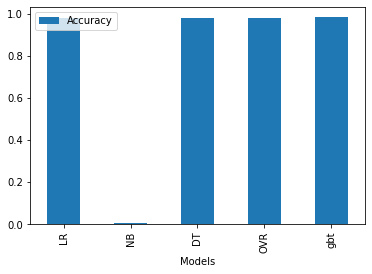

In [44]:
df = pd.DataFrame({'Models': ['LR', 'NB', 'DT','OVR','gbt'], 'Accuracy': [lracc, nbacc, dtacc,OVRacc,gbtAcc]})
df.plot.bar(x='Models', y='Accuracy') 

<AxesSubplot:>

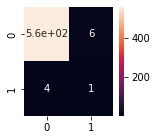

In [53]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import MulticlassMetrics
cm=metrics.confusionMatrix().toArray()
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (2,2))
sn.heatmap(df_cm, annot=True)

In [ ]:
#knn suport vector decision tree gradient descent naive bayes 
#confusion matrix roc 
# done LogisticRegression LinearSVC RandomForestClassifier MulticlassClassificationEvaluator